# **데이터 및 라이브러리 로드**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import warnings
warnings.filterwarnings(action='ignore')

path= '/content/drive/MyDrive/data/mercari-price-suggestion-challenge/'

mercari_df = pd.read_csv(os.path.join(path, 'train.tsv'), sep='\t')
mercari_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [33]:
mercari_df.shape

(1482535, 11)

# **데이터 전처리**

In [9]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


brand_name column에 null값이 많음

#### 타겟값의 분포도 확인

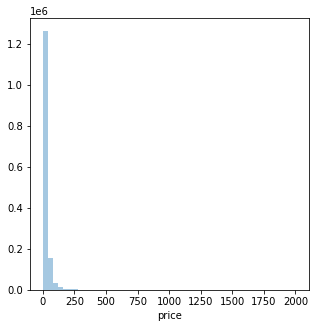

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(5,5))
sns.distplot(y_train_df, kde=False)

#### 타겟값 로그 변환

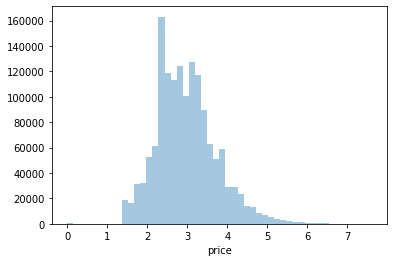

In [8]:
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

타겟값이 정규분포형으로 변환

In [10]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

#### 각 피쳐 유형

In [17]:
from termcolor import colored

print(colored("item_condition_id 피쳐 유형: \n", 'blue'), mercari_df['item_condition_id'].value_counts())
print('\n')
print(colored("shipping 피쳐 유형: \n", 'blue'), mercari_df['shipping'].value_counts())

item_condition_id 피쳐 유형: 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


shipping 피쳐 유형: 
 0    819435
1    663100
Name: shipping, dtype: int64


In [18]:
# item description에 설명이 없는 것 count
boolean_cond = (mercari_df['item_description'] == 'No description yet')
mercari_df[boolean_cond]['item_description'].count()

82489

#### category name 피쳐 '/'기준 분리하여 개별 컬럼 재생성

In [19]:
mercari_df['category_name'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Bags and Purses/Diaper Bag                   1
Handmade/Pets/Blanket                                 1
Handmade/Holidays/Patriotic                           1
Handmade/Housewares/Bathroom                          1
Handmade/Furniture/Shelf                              1
Name: category_name, Length: 1287, dtype: int64

In [24]:
# category '/' 분할 함수
def split_cat(category_name):
  try: 
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']
  
# 대분류, 중분류, 소분류로 분류
mercari_df['cat_1'], mercari_df['cat_2'], mercari_df['cat_3'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류, 중분류, 소분류 갯수
print('대분류 유형: ', mercari_df['cat_1'].value_counts())
print('중분류 갯수: ', mercari_df['cat_2'].nunique())
print('소분류 갯수: ', mercari_df['cat_3'].nunique())

대분류 유형:  Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_1, dtype: int64
중분류 갯수:  114
소분류 갯수:  871


#### Null 값 처리

In [25]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
cat_1                     0
cat_2                     0
cat_3                     0
dtype: int64

In [26]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['item_description'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# **피쳐 인코딩, 벡터화**

In [27]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
 8   cat_1              1482535 non-null  object 
 9   cat_2              1482535 non-null  object 
 10  cat_3              1482535 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


##### brand_name 피쳐

In [30]:
print('brand_name 유형 건수 :', mercari_df['brand_name'].nunique())

brand_name 유형 건수 : 4810


In [32]:
print('name 유형 건수 :', mercari_df['name'].nunique())

name 유형 건수 : 1225273


##### item_description 문자열 갯수

In [34]:
pd.set_option('max_colwidth', 200)

print('item_description 평균 문자열 갯수:', mercari_df['item_description'].str.len().mean())

item_description 평균 문자열 갯수: 145.7113889385411


#### **피쳐 벡터화**
- name : count 
- item_description : TF-IDF

In [35]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

# name 피쳐
cnt_vec = CountVectorizer(max_features=30000)
X_name = cnt_vec.fit_transform(mercari_df['name'])

# item_description 피쳐
tfidf_vec = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descript = tfidf_vec.fit_transform(mercari_df['item_description'])

print("name vecterization shape: ", X_name.shape)
print("item_description vecterization shape: ", X_descript.shape)

name vecterization shape:  (1482535, 30000)
item_description vecterization shape:  (1482535, 50000)


#### **원핫인코딩 변환 후 희소행렬 최적화 형태로 저장**

In [37]:
from sklearn.preprocessing import LabelBinarizer

# brand_name 피쳐
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

# item_condition_id 피쳐
lb_item_condition_id = LabelBinarizer(sparse_output=True)
X_item_condition_id = lb_item_condition_id.fit_transform(mercari_df['item_condition_id'])

# shipping 피쳐
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_1, cat_2, cat_3 피쳐
lb_cat_1 = LabelBinarizer(sparse_output=True)
X_cat_1 = lb_cat_1.fit_transform(mercari_df['cat_1'])

lb_cat_2 = LabelBinarizer(sparse_output=True)
X_cat_2 = lb_cat_2.fit_transform(mercari_df['cat_1'])

lb_cat_3 = LabelBinarizer(sparse_output=True)
X_cat_3 = lb_cat_3.fit_transform(mercari_df['cat_1'])

In [39]:
print(type(X_brand), type(X_item_condition_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_condition_id shape:{1}'.format(X_brand.shape, X_item_condition_id.shape))
print('X_shipping shape:{0}, X_cat_1 shape:{1}'.format(X_shipping.shape, X_cat_1.shape))
print('X_cat_2 shape:{0}, X_cat_3 shape:{1}'.format(X_cat_2.shape, X_cat_3.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_condition_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_1 shape:(1482535, 11)
X_cat_2 shape:(1482535, 11), X_cat_3 shape:(1482535, 11)


In [40]:
import gc
gc.collect()

1117

#### 피쳐벡터화 피쳐와 원핫인코딩화 피쳐 희소행렬들 결합

In [41]:
from scipy.sparse import hstack

sparse_matrix_list = (X_name, X_descript, X_brand, X_item_condition_id, X_shipping,
                      X_cat_1, X_cat_2, X_cat_3)

X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse))
print(X_features_sparse.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(1482535, 84849)


# **모델 구축**

#### rmsle 정의


In [42]:
def rmsle(y, y_pred):
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
  # 로그변환이 되어있으므로 복구
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle 값
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

#### 여러 모델 학습/예측을 위한 함수 생성
* 여러 희소 행렬을 hstack()으로 결합한 뒤 학습과 테스트 데이터 세트로 분할 후 모델 학습 및 예측을 수행

In [43]:
import gc 
from  scipy.sparse import hstack
from sklearn.model_selection import train_test_split , cross_val_score

def model_train_predict(model,matrix_list):
    # sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=216)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

#### Lidge 선형 회귀 모델

In [44]:
from sklearn.linear_model import Ridge , LogisticRegression

linear_model = Ridge(solver = 'lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_descript, X_brand, X_item_condition_id, X_shipping,
                      X_cat_1, X_cat_2, X_cat_3)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print("rmsle: ", evaluate_org_price(y_test, linear_preds))

rmsle:  0.48703297925833866


In [45]:
# Item description 피쳐가 없을 때
sparse_matrix_list = (X_name, X_brand, X_item_condition_id, X_shipping,
                      X_cat_1, X_cat_2, X_cat_3)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print("rmsle: ", evaluate_org_price(y_test, linear_preds))

rmsle:  0.5276743826600357


# LightGBM 회귀 모델

In [47]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_name, X_descript, X_brand, X_item_condition_id, X_shipping,
                      X_cat_1, X_cat_2, X_cat_3)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=216)
lgbm_preds , y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print("rmsle: ", evaluate_org_price(y_test, lgbm_preds))

rmsle:  0.46973196295270087


In [48]:
import gc
gc.collect()

335

#### lgbm + Ridge ensemble

In [50]:
preds = lgbm_preds * 0.48 + linear_preds * 0.52
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4777924822201176
